## Importe

In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
import jupyter_black

In [2]:
# Run Black for Better Formatting
jupyter_black.load()

In [3]:
# Display all columns
pd.set_option("display.max_columns", None)

In [4]:
# Importing File
fifa = (
    pd.read_csv("players_fifa23.csv")
    .drop_duplicates(subset=["FullName", "Club"])
    .reset_index()
)

## Data Cleaning

In [5]:
# Setting Full Name as Index
fifa2 = fifa.set_index("FullName")

In [6]:
# Selection of numeric attributes that are useful for player recommendation
fifa3 = fifa2._get_numeric_data()
fifa4 = fifa3.drop(
    [
        "index",
        "ID",
        "Growth",
        "TotalStats",
        "BaseStats",
        "ValueEUR",
        "WageEUR",
        "ReleaseClause",
        "ContractUntil",
        "ClubNumber",
        "ClubJoined",
        "OnLoad",
        "NationalNumber",
        "IntReputation",
        "GKDiving",
        "GKHandling",
        "GKKicking",
        "GKPositioning",
        "GKReflexes",
        "STRating",
        "LWRating",
        "LFRating",
        "CFRating",
        "RFRating",
        "RWRating",
        "CAMRating",
        "LMRating",
        "CMRating",
        "RMRating",
        "LWBRating",
        "CDMRating",
        "RWBRating",
        "LBRating",
        "CBRating",
        "RBRating",
        "GKRating",
    ],
    axis=1,
)

In [7]:
# Minmax Scaling
scaler = MinMaxScaler()

fifa5 = pd.DataFrame(
    scaler.fit_transform(fifa4), columns=fifa4.columns, index=fifa4.index
)

In [8]:
# Weighting: Overall-Skill & Potential should get a higher weight
fifa5["Overall"] = fifa5["Overall"] * 4
fifa5["Potential"] = fifa5["Potential"] * 2

## Recommendation System

In [9]:
# Instanciating of KNN and Fitting with Dataset
knn = NearestNeighbors()
knn.fit(fifa5)

NearestNeighbors()

In [10]:
# Calculation of Distance and Rank with KNN
distance, rank = knn.kneighbors(fifa5, 11)

In [11]:
# Buiding a Dict with Player Index and Player Name
id_name = fifa["FullName"].to_dict()

In [12]:
# Column with Player Name and Club
id_name_club = fifa[["FullName", "Club"]].drop_duplicates()
id_name_club["Name and Club"] = (
    id_name_club.FullName + " " + "(" + id_name_club.Club + ")"
)
id_name_club = id_name_club["Name and Club"].to_dict()

In [13]:
# Building a DataFrame with the Distances between Players
dist_df = pd.DataFrame(
    columns=[f"rank_{i}" for i in range(1, 11)],
    index=fifa5.index,
    data=distance[:, 1:],
)

In [14]:
# Building a DataFrame with Indices of similar Players and mapping it to Players id_name
similar_df = pd.DataFrame(
    columns=[f"rank_{i}_name" for i in range(1, 11)],
    index=fifa5.index,
    data=rank[:, 1:],
).apply(lambda x: x.map(id_name))

In [15]:
# Building a DataFrame with Indices of similar Players and mapping it to Players id_name with Club
similar_with_club_df = pd.DataFrame(
    columns=[f"rank_{i}_name_club" for i in range(1, 11)],
    index=fifa5.index,
    data=rank[:, 1:],
).apply(lambda x: x.map(id_name_club))

In [16]:
# Joining the different DataFrames together
df_data = fifa4.join(similar_df).join(dist_df).join(similar_with_club_df)

In [17]:
# Droping rows with Nans
df_data = df_data.dropna(how="any")

In [18]:
def similar_player(player_name):
    player_name = df_data[df_data.index == player_name].index[0]

    ## Bar chart
    plt.figure(figsize=(12, 6))

    Xaxis = df_data.loc[player_name].values[-20:-10]
    Yaxis = df_data.loc[player_name].values[-10:]

    fig = sns.barplot(data=df_data, x=Xaxis, y=Yaxis, palette="mako")
    fig.set_title('Players similar to  " ' + str(player_name) + ' "')
    plt.xlabel("Difference", fontsize=14)
    plt.show()

    ## Table display

    display_df = pd.concat(
        [
            df_data[df_data.index == player_name],
            df_data.loc[df_data.loc[player_name].values[42:52]],
        ]
    ).iloc[:, :42]

    display(display_df)

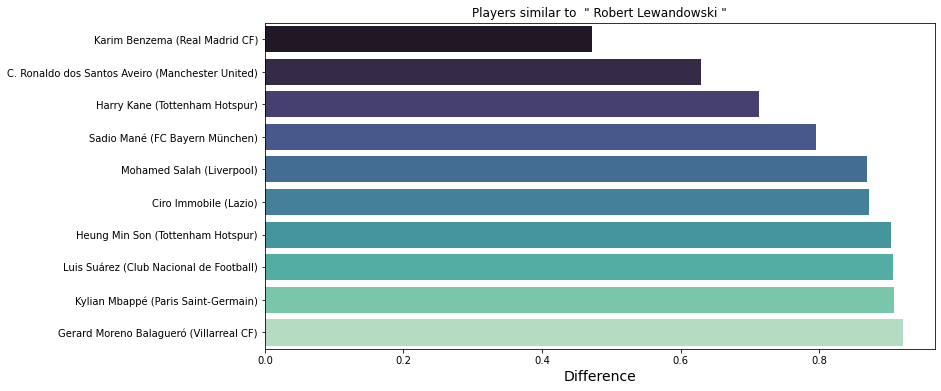

,Age,Height,Weight,Overall,Potential,WeakFoot,SkillMoves,PaceTotal,ShootingTotal,PassingTotal,DribblingTotal,DefendingTotal,PhysicalityTotal,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
FullName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Robert Lewandowski,33,185,81,91,91,4,4,75,91,79,86,44,83,71,94,91,84,89,85,79,85,70,89,76,75,77,93,82,91,85,76,87,84,81,49,94,81,90,88,35,42,19
Karim Benzema,34,185,81,91,91,4,4,80,88,83,87,39,78,75,92,90,89,88,87,82,73,76,91,79,80,78,92,72,87,79,82,82,80,63,39,92,89,84,90,43,24,18
C. Ronaldo dos Santos Aveiro,37,187,83,90,90,4,5,81,92,78,85,34,75,80,93,90,80,86,85,81,79,75,88,79,83,77,94,67,93,95,76,77,90,63,29,95,76,90,95,24,32,24
Harry Kane,28,188,89,89,89,5,3,68,91,83,82,47,82,80,93,85,84,87,83,82,65,85,84,67,69,68,92,71,92,79,83,83,86,80,44,94,87,92,92,50,36,38
Sadio Mané,30,174,69,89,89,4,4,90,83,80,88,44,77,78,86,84,84,75,88,77,64,71,86,91,90,93,91,88,83,87,85,72,78,75,35,90,84,75,84,42,42,38
Mohamed Salah,30,175,71,90,90,3,4,90,89,82,90,45,75,80,93,59,84,84,90,84,69,77,88,89,91,90,93,91,83,69,87,75,85,63,55,92,85,86,92,38,43,41
Ciro Immobile,32,185,85,86,86,4,3,85,87,68,80,39,75,55,91,81,79,85,79,70,58,57,81,84,86,75,87,84,86,82,78,74,80,73,40,90,71,88,76,34,33,32
Heung Min Son,29,183,78,89,89,5,4,88,89,82,86,42,69,83,91,68,84,79,87,85,74,74,84,85,90,85,91,76,88,60,88,64,89,62,39,91,84,73,89,47,34,33
Luis Suárez,35,182,86,84,84,4,3,70,86,78,78,46,81,75,87,84,78,88,76,85,81,73,81,73,68,70,86,77,86,69,71,84,84,87,39,90,80,82,86,41,45,38


In [41]:
similar_player("Robert Lewandowski")